# Imports

In [1]:
import gc, pickle, re, json

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D

import matplotlib.pyplot as plt 
%matplotlib inline

/home/kaushik/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# UDFs

In [2]:
# Extract meta into features
def meta_to_features(df):
    for index, row in df.iterrows():
        meta = row.meta
        num_entries_per_key_in_row = {}

        for item in meta:
            key = item['key']
            value = item['value']

            if key not in num_entries_per_key_in_row.keys():
                num_entries_per_key_in_row[key] = 1
            else:
                num_entries_per_key_in_row[key] += 1

            key = f'{key}_{num_entries_per_key_in_row[key]}'
            if key not in df.columns:
                df[key] = None

            df.loc[index, key] = value

def reomve_stopwords(df, colname):
    en_stops = set(stopwords.words('english'))

    for index, row in df.iterrows():
        words = word_tokenize(row[colname]) 
        words = [w for w in words if not w in en_stops]
        df.loc[index, colname] = str(' '.join(words))

# Load the data

In [3]:
tweet_file_path = 'data/alltweets.json' 
other_file_path = 'data/allothers.json'

In [4]:
with open(other_file_path, encoding="utf8") as data_file:    
    data = json.load(data_file)

with open(tweet_file_path, encoding="utf8") as data_file:    
    data.extend(json.load(data_file))

data

[{'article_type': 'Product Review',
  'content': 'The best of all...',
  'date': '2005-01-31T18:30:00.000Z',
  'id': '00765d7b-b207-4f58-9446-4ec97a3b9b36',
  'image_url': None,
  'is_rejected': False,
  'is_reviewed': True,
  'is_upload_reqd': False,
  'last_tagged_date': None,
  'link': 'https://www.thetoptens.com/i/#kent-424498',
  'meta': [{'key': 'Brand', 'value': 'Kent'},
   {'key': 'Product Category', 'value': 'Cigarette'},
   {'key': 'Quality / Overall', 'value': 'best'}],
  'review_date': '2018-11-08T10:26:45.655Z',
  'sentiment': 'Very Positive',
  'source': 'The Top Tens',
  'title': 'Kent: The best of all...'},
 {'article_type': 'Product Review',
  'content': 'Best cigarette of all times',
  'date': '2005-01-31T18:30:00.000Z',
  'id': '010d85b1-09fc-4eab-940a-997f6c5da7cd',
  'image_url': None,
  'is_rejected': False,
  'is_reviewed': True,
  'is_upload_reqd': False,
  'last_tagged_date': None,
  'link': 'https://www.thetoptens.com/cigarette-brands/marlboro-41004.asp',
  'm

In [5]:
df_raw = pd.DataFrame(data)
df_raw.head()

,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
0,Product Review,The best of all...,2005-01-31T18:30:00.000Z,00765d7b-b207-4f58-9446-4ec97a3b9b36,None,False,True,False,None,https://www.thetoptens.com/i/#kent-424498,"[{'key': 'Brand', 'value': 'Kent'}, {'key': 'P...",2018-11-08T10:26:45.655Z,Very Positive,The Top Tens,Kent: The best of all...
1,Product Review,Best cigarette of all times,2005-01-31T18:30:00.000Z,010d85b1-09fc-4eab-940a-997f6c5da7cd,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-08T10:28:00.027Z,Very Positive,The Top Tens,Marlboro: Best cigarette of all times
2,Product Review,As best as it's,2005-01-31T18:30:00.000Z,001790de-bf8f-473b-8247-8372a6569c9a,None,False,True,False,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-08T10:28:27.142Z,Very Positive,The Top Tens,Camel: As best as it's
3,Product Review,Camels are the best cigarette that I have ever...,2005-01-31T18:30:00.000Z,01b7002c-dad0-420e-a2dc-cc12fe75b175,None,False,True,False,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-08T10:28:48.621Z,Very Positive,The Top Tens,Camel: Camels are the best cigarette that I ha...
4,Product Review,Dunhill swich is the best,2005-01-31T18:30:00.000Z,00436e38-b775-43e1-9348-272e433f12bb,None,False,True,False,None,https://www.thetoptens.com/i/#dunhill-351703,"[{'key': 'Brand', 'value': 'Dunhill'}, {'key':...",2018-11-08T10:29:45.334Z,Very Positive,The Top Tens,Dunhill: Dunhill swich is the best


In [6]:
with open('data/df_raw_non.pkl', 'wb') as f:
    pickle.dump(df_raw, f)

# Feature engineering

In [7]:
with open('data/df_raw.pkl', 'rb') as f:
    df_raw = pickle.load(f)

In [8]:
df = df_raw.copy()

In [9]:
df = df[df.is_reviewed == True]
df.shape

(12640, 15)

In [92]:
df.loc[df.sentiment=='No Sentiment', 'content'].iloc[0]

'Moved to the UK from Chicago and the cigs in London tasted awful being after burning through my carton of Camel filters. Took awhile, but everything about Dunhill is excellent. Tobacco quality, look/feel, burn rate, and most important is the unique sweety taste.'

In [10]:
df.content = df.title + " " + df.content
df.drop('title', axis=1, inplace=True)
df.head()

,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source
0,Product Review,Kent: The best of all... The best of all...,2005-01-31T18:30:00.000Z,00765d7b-b207-4f58-9446-4ec97a3b9b36,None,False,True,False,None,https://www.thetoptens.com/i/#kent-424498,"[{'key': 'Brand', 'value': 'Kent'}, {'key': 'P...",2018-11-08T10:26:45.655Z,Very Positive,The Top Tens
1,Product Review,Marlboro: Best cigarette of all times Best cig...,2005-01-31T18:30:00.000Z,010d85b1-09fc-4eab-940a-997f6c5da7cd,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-08T10:28:00.027Z,Very Positive,The Top Tens
2,Product Review,Camel: As best as it's As best as it's,2005-01-31T18:30:00.000Z,001790de-bf8f-473b-8247-8372a6569c9a,None,False,True,False,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-08T10:28:27.142Z,Very Positive,The Top Tens
3,Product Review,Camel: Camels are the best cigarette that I ha...,2005-01-31T18:30:00.000Z,01b7002c-dad0-420e-a2dc-cc12fe75b175,None,False,True,False,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-08T10:28:48.621Z,Very Positive,The Top Tens
4,Product Review,Dunhill: Dunhill swich is the best Dunhill swi...,2005-01-31T18:30:00.000Z,00436e38-b775-43e1-9348-272e433f12bb,None,False,True,False,None,https://www.thetoptens.com/i/#dunhill-351703,"[{'key': 'Brand', 'value': 'Dunhill'}, {'key':...",2018-11-08T10:29:45.334Z,Very Positive,The Top Tens


In [11]:
#df.iloc[11105, :].meta
#df.iloc[11106, :].meta
#df = df.iloc[11105:11107, :]
#df.head()

In [12]:
# Extract meta into features
meta_to_features(df)
df.drop('meta', axis=1, inplace=True)
df.head()

,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,review_date,sentiment,source,Brand_1,Product Category_1,Quality / Overall_1,Product_1,Flavour_1,Smell_1,Design_1,Quality / Overall_2,Burn Rate_1,Brand_2,Country / Region_1,Key Phrase_1,Strength_1,Filter_1,Packaging_1,Taste_1,Burn Rate_2,Brand_3,Key Phrase_2,Taste_2,Flavour_2,Price_1,Brand_4,Brand_5,Brand_6,Body_1,Product_2,Product_3,Product_4,Packaging_2,Strength_2,Design_2,Subcategory_1,Flavour_3,Quality / Overall_3,Price_2,Filter_2,Body_2,Taste_3,Brand_7,Brand_8,Brand_9,Strength_3,Company_1,Brand_10,Body_3,Quality / Overall_4,Smell_2,Product Category_2,Quality / Overall_5,Rating_1,Key Phrase_3,Product_5,Product_6,Product Category_3,Product Category_4,Subcategory_2,Country / Region_2,Product_7,Country / Region_3,Filter_3,Flavour_4,Key Phrase_4,Battery and charging_1,Service_1,Flavour_5,Flavour_6,Flavour_7,Flavour_8,Flavour_9,Flavour_10,Flavour_11,Flavour_12,Flavour_13,Puff Count_1,Puff Count_2,Puff Count_3,Service_2,Company_2,Packaging_3,Burn Rate_3,Strength_4,Price_3,Battery and charging_2,Taste_4,Smell_3,Brand_11,Brand_12,Brand_13,Country / Region_4,Lag Time_1,Product_8,Country / Region_5,Country / Region_6,Country / Region_7,Country / Region_8,Country / Region_9,Country / Region_10,Country / Region_11,Country / Region_12,Country / Region_13,Country / Region_14,Business news- Others_1,Business news- Advertising_1,Brand_14,Brand_15,Brand_16,Brand_17,Brand_18,Brand_19,Brand_20,Brand_21,Brand_22,Brand_23,Brand_24,Key Phrase_5,Key Phrase_6,Key Phrase_7,Tobacco control- Plain packaging_1,Tobacco control- Regulatory acts_1,Tobacco control- Regulatory acts_2,Tobacco control- Regulatory acts_3,Tobacco control- Regulatory acts_4,Company_3,Company_4,Company_5,Company_6,Illicit trade_1,Illicit trade_2,Illicit trade_3,Business news- Advertising_2,Business news- Advertising_3,Business news- Advertising_4,Business news- Advertising_5,Tobacco control- Pricing and taxes_1,Government / Regulatory_1,Product_9,Product_10,Product_11,Product_12,Product_13,Product_14,Product_15,Product_16,Product_17,Battery and charging_3,Battery and charging_4,Subcategory_3,Tobacco control- Social Media_1,Design_3,Design_4,Filter_4,Quality / Overall_6,Smell_4,Strength_5,Strength_6,Filter_5
0,Product Review,Kent: The best of all... The best of all...,2005-01-31T18:30:00.000Z,00765d7b-b207-4f58-9446-4ec97a3b9b36,None,False,True,False,None,https://www.thetoptens.com/i/#kent-424498,2018-11-08T10:26:45.655Z,Very Positive,The Top Tens,Kent,Cigarette,best,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Product Review,Marlboro: Best cigarette of all times Best cig...,2005-01-31T18:30:00.000Z,010d85b1-09fc-4eab-940a-997f6c5da7cd,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,2018-11-08T10:28:00.027Z,Very Positive,The Top Tens,Marlboro,Cigarette,best,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [13]:
df.content = df.content.apply(lambda x: x.lower())
df.content = df.content.apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
reomve_stopwords(df, 'content')
df.head()

,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,review_date,sentiment,source,Brand_1,Product Category_1,Quality / Overall_1,Product_1,Flavour_1,Smell_1,Design_1,Quality / Overall_2,Burn Rate_1,Brand_2,Country / Region_1,Key Phrase_1,Strength_1,Filter_1,Packaging_1,Taste_1,Burn Rate_2,Brand_3,Key Phrase_2,Taste_2,Flavour_2,Price_1,Brand_4,Brand_5,Brand_6,Body_1,Product_2,Product_3,Product_4,Packaging_2,Strength_2,Design_2,Subcategory_1,Flavour_3,Quality / Overall_3,Price_2,Filter_2,Body_2,Taste_3,Brand_7,Brand_8,Brand_9,Strength_3,Company_1,Brand_10,Body_3,Quality / Overall_4,Smell_2,Product Category_2,Quality / Overall_5,Rating_1,Key Phrase_3,Product_5,Product_6,Product Category_3,Product Category_4,Subcategory_2,Country / Region_2,Product_7,Country / Region_3,Filter_3,Flavour_4,Key Phrase_4,Battery and charging_1,Service_1,Flavour_5,Flavour_6,Flavour_7,Flavour_8,Flavour_9,Flavour_10,Flavour_11,Flavour_12,Flavour_13,Puff Count_1,Puff Count_2,Puff Count_3,Service_2,Company_2,Packaging_3,Burn Rate_3,Strength_4,Price_3,Battery and charging_2,Taste_4,Smell_3,Brand_11,Brand_12,Brand_13,Country / Region_4,Lag Time_1,Product_8,Country / Region_5,Country / Region_6,Country / Region_7,Country / Region_8,Country / Region_9,Country / Region_10,Country / Region_11,Country / Region_12,Country / Region_13,Country / Region_14,Business news- Others_1,Business news- Advertising_1,Brand_14,Brand_15,Brand_16,Brand_17,Brand_18,Brand_19,Brand_20,Brand_21,Brand_22,Brand_23,Brand_24,Key Phrase_5,Key Phrase_6,Key Phrase_7,Tobacco control- Plain packaging_1,Tobacco control- Regulatory acts_1,Tobacco control- Regulatory acts_2,Tobacco control- Regulatory acts_3,Tobacco control- Regulatory acts_4,Company_3,Company_4,Company_5,Company_6,Illicit trade_1,Illicit trade_2,Illicit trade_3,Business news- Advertising_2,Business news- Advertising_3,Business news- Advertising_4,Business news- Advertising_5,Tobacco control- Pricing and taxes_1,Government / Regulatory_1,Product_9,Product_10,Product_11,Product_12,Product_13,Product_14,Product_15,Product_16,Product_17,Battery and charging_3,Battery and charging_4,Subcategory_3,Tobacco control- Social Media_1,Design_3,Design_4,Filter_4,Quality / Overall_6,Smell_4,Strength_5,Strength_6,Filter_5
0,Product Review,kent best best,2005-01-31T18:30:00.000Z,00765d7b-b207-4f58-9446-4ec97a3b9b36,None,False,True,False,None,https://www.thetoptens.com/i/#kent-424498,2018-11-08T10:26:45.655Z,Very Positive,The Top Tens,Kent,Cigarette,best,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Product Review,marlboro best cigarette times best cigarette t...,2005-01-31T18:30:00.000Z,010d85b1-09fc-4eab-940a-997f6c5da7cd,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,2018-11-08T10:28:00.027Z,Very Positive,The Top Tens,Marlboro,Cigarette,best,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

In [14]:
with open('data/df.pkl', 'wb') as f:
    pickle.dump(df, f)

# Filter

In [2]:
with open('data/df.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
print(set(df.sentiment))
print(len(df))
df.sentiment.value_counts()

{'No Sentiment', 'Neutral', 'Negative', 'Very Negative', 'Very Positive', 'Positive'}
12640


No Sentiment     8738
Very Positive    2176
Positive          914
Negative          374
Very Negative     244
Neutral           194
Name: sentiment, dtype: int64

In [4]:
#df = df.loc[df.sentiment != 'No Sentiment']
df.loc[df.sentiment=='No Sentiment', 'sentiment'] = 'Neutral'

df.loc[df.sentiment=='Very Positive', 'sentiment'] = 'Positive'
df.loc[df.sentiment=='Very Negative', 'sentiment'] = 'Negative'

# Extract test data

In [15]:
y = df['sentiment'].copy()
X = df.drop('sentiment', axis=1).copy()

n_levels = len(set(y))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
len(X_train)
len(X_test)

8848

3792

# Model

## Hype-parameters

In [10]:
max_vocab_size = 5000
max_seq_len = 500

In [11]:
embedding_size = 64
lstm_out = 128
spatial_dropout_rate = 0.4
dropout = 0.2
recurrent_dropout = 0.2
output_units = n_levels

## Preprocess

In [12]:
tokenizer = Tokenizer(num_words=max_vocab_size, split=' ')
tokenizer.fit_on_texts(X_train.content.values)

## Prepare for keras

In [24]:
y_train = pd.get_dummies(y_train).values.copy()

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train.content.values), maxlen=max_seq_len)
X_train.shape

(8848, 500)

## Build architecture

In [26]:
model = Sequential()
model.add(Embedding(max_vocab_size, embedding_size, input_length=max_seq_len))
model.add(SpatialDropout1D(spatial_dropout_rate))
model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
model.add(Dense(output_units, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 419,203
Trainable params: 419,203
Non-trainable params: 0
_________________________________________________________________
None


## Split

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
len(X_train)
len(X_val)

7963

885

## Fit

In [28]:
batch_size = 32
epochs = 4

In [29]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          class_weight='balanced',
          epochs=epochs, batch_size=batch_size, 
          verbose=2);

Train on 7963 samples, validate on 885 samples
Epoch 1/4
 - 152s - loss: 0.5744 - acc: 0.7834 - val_loss: 0.4567 - val_acc: 0.8226
Epoch 2/4
 - 154s - loss: 0.4018 - acc: 0.8507 - val_loss: 0.4445 - val_acc: 0.8271
Epoch 3/4
 - 155s - loss: 0.3260 - acc: 0.8865 - val_loss: 0.4464 - val_acc: 0.8328
Epoch 4/4
 - 155s - loss: 0.2806 - acc: 0.9014 - val_loss: 0.4738 - val_acc: 0.8237


In [30]:
model.save('data/model.h5')

# Predict

In [13]:
model = load_model('data/model.h5')

## Evaluate

In [17]:
y_test_dummies = pd.get_dummies(y_test)
y_test = y_test_dummies.values.copy()

X_test = pad_sequences(tokenizer.texts_to_sequences(X_test.content.values), maxlen=max_seq_len)
X_test.shape

(3792, 500)

In [18]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8346518987341772


## Analyze

In [53]:
pred = model.predict_classes(X_test)
pred[:5]
y_test_dummies.head()

array([1, 2, 1, 1, 2])

,Negative,Neutral,Positive
73373,0,1,0
146,0,0,1
79057,0,1,0
75531,0,1,0
1079,1,0,0


In [36]:
y_test_classes = pd.DataFrame({'actual': y_test_dummies.columns[np.where(y_test_dummies != 0)[1]]}, 
                              index=y_test_dummies.index)
y_test_classes['pred'] = pred
y_test_classes.head()

,actual,pred
73373,Neutral,1
146,Positive,2
79057,Neutral,1
75531,Neutral,1
1079,Negative,2


In [37]:
map_dummies = {}
code = 0

for col in y_test_dummies.columns:
    map_dummies[code] = col
    code += 1

y_test_classes['pred'] = y_test_classes['pred'].map(map_dummies)
y_test_classes.head()

,actual,pred
73373,Neutral,Neutral
146,Positive,Positive
79057,Neutral,Neutral
75531,Neutral,Neutral
1079,Negative,Positive


In [50]:
# Coarse mapping
'''
map_coarse_classes = {'Very Positive': 'Positive', 'Very Negative': 'Negative', 
                      'Negative': 'Negative', 'Positive': 'Positive', 'Neutral': 'Neutral', 
                      'No Sentiment': 'No Sentiment'}
y_test_classes['actual'] = y_test_classes['actual'].map(map_coarse_classes)
y_test_classes['pred'] = y_test_classes['pred'].map(map_coarse_classes)
y_test_classes.head()
'''

"\nmap_coarse_classes = {'Very Positive': 'Positive', 'Very Negative': 'Negative', \n                      'Negative': 'Negative', 'Positive': 'Positive', 'Neutral': 'Neutral', \n                      'No Sentiment': 'No Sentiment'}\ny_test_classes['actual'] = y_test_classes['actual'].map(map_coarse_classes)\ny_test_classes['pred'] = y_test_classes['pred'].map(map_coarse_classes)\ny_test_classes.head()\n"

In [39]:
print(classification_report(y_test_classes.actual, y_test_classes.pred))
print(pd.crosstab(y_test_classes.actual, y_test_classes.pred,
                  rownames=['True'], colnames=['Predicted'], margins=True))

             precision    recall  f1-score   support

   Negative       0.68      0.41      0.51       193
    Neutral       0.87      0.91      0.89      2640
   Positive       0.74      0.71      0.73       959

avg / total       0.83      0.83      0.83      3792

Predicted  Negative  Neutral  Positive   All
True                                        
Negative         79       86        28   193
Neutral          30     2403       207  2640
Positive          7      269       683   959
All             116     2758       918  3792


## Inspect

In [40]:
with open('data/df_raw.pkl', 'rb') as f:
    df_raw = pickle.load(f)

In [41]:
y_test_classes['correct'] = y_test_classes.apply(lambda row: row['actual']==row['pred'], axis=1)
y_test_classes.head()

,actual,pred,correct
73373,Neutral,Neutral,True
146,Positive,Positive,True
79057,Neutral,Neutral,True
75531,Neutral,Neutral,True
1079,Negative,Positive,False


In [42]:
y_test_classes = y_test_classes.merge(df_raw, how='inner', left_index=True, right_index=True)
y_test_classes.head()

,actual,pred,correct,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
73373,Neutral,Neutral,True,Feed,@truthinitiative @FDATobacco Untruthinitative ...,2018-11-13T18:30:00.000Z,0c77a08f-20a1-4ae5-a606-7ae52bdf6c24,None,False,True,True,None,https://twitter.com/i/web/status/1063149292834...,"[{'key': 'Brand', 'value': 'JUUL'}, {'key': 'P...",2018-11-26T07:11:07.634Z,No Sentiment,Twitter,@truthinitiative @FDATobacco Untruthinitative ...
146,Positive,Positive,True,Product Review,Kings is the best,2005-01-31T18:30:00.000Z,0d94adf1-75e4-4ddd-b33c-37193ce7472c,None,False,True,False,None,https://www.thetoptens.com/i/#gold-flake-379161,"[{'key': 'Brand', 'value': 'Gold Flake'}, {'ke...",2018-11-09T06:12:16.729Z,Very Positive,The Top Tens,Gold Flake: Kings is the best
79057,Neutral,Neutral,True,Feed,Juul banned before AR-15s. Got it.,2018-11-13T18:30:00.000Z,106b1408-0a9b-44c4-9ce1-b382639a60d5,None,False,True,True,None,https://twitter.com/i/web/status/1063119778225...,"[{'key': 'Brand', 'value': 'JUUL'}, {'key': 'P...",2018-12-10T06:26:26.022Z,No Sentiment,Twitter,Juul banned before AR-15s. Got it.
75531,Neutral,Neutral,True,Feed,@adam22 @JuiceWorlddd peep the juul pods in th...,2018-11-14T18:30:00.000Z,0e89c70a-5e23-481e-b6d0-459a5e556fa8,None,False,True,False,None,https://twitter.com/i/web/status/1063299259863...,"[{'key': 'Brand', 'value': 'JUUL'}, {'key': 'P...",2018-11-28T10:14:16.230Z,No Sentiment,Twitter,@adam22 @JuiceWorlddd peep the juul pods in th...
1079,Negative,Positive,False,Product Review,Too light and expensive for me!,2005-01-31T18:30:00.000Z,ad21a30f-b35f-4218-b64c-340db1e2b7e9,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-22T05:36:21.456Z,Negative,The Top Tens,Marlboro: Too light and expensive for me!


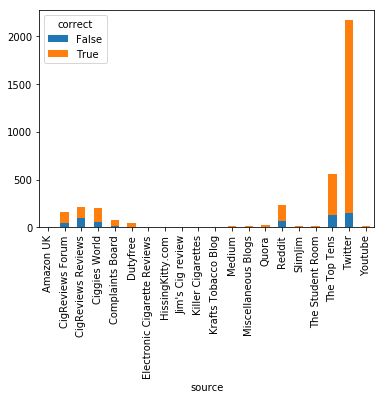

In [43]:
pd.crosstab(y_test_classes.source, y_test_classes.correct).plot(kind='bar', stacked=True);

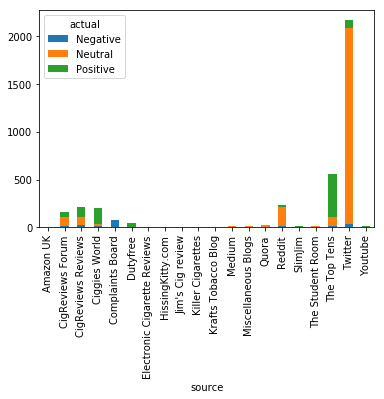

In [91]:
pd.crosstab(y_test_classes.source, y_test_classes.actual).plot(kind='bar', stacked=True);

### Incorrect

In [68]:
incorrect = y_test_classes[y_test_classes.correct == False]
incorrect.head(20)

,actual,pred,correct,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
1079,Negative,Positive,False,Product Review,Too light and expensive for me!,2005-01-31T18:30:00.000Z,ad21a30f-b35f-4218-b64c-340db1e2b7e9,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-22T05:36:21.456Z,Negative,The Top Tens,Marlboro: Too light and expensive for me!
8525,Neutral,Positive,False,Product Review,I find that these are too weak and often taste...,2014-12-20T18:30:00.000Z,b682e32f-4fdc-4e08-aed6-bd5ff6bb70f0,None,False,True,True,None,https://www.cigreviews.com/view-review/Marlbor...,"[{'key': 'Rating', 'value': '2.0'}, {'key': 'S...",2018-11-23T07:33:38.359Z,No Sentiment,CigReviews Reviews,Marlboro Smooth: I find that these are too wea...
35,Neutral,Positive,False,Product Review,Marlboro lights the best. Benson Gold used to ...,2005-01-31T18:30:00.000Z,01e6ae49-e661-4715-906a-0f0795c154c2,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-08T11:09:19.953Z,No Sentiment,The Top Tens,Marlboro: Marlboro lights the best. Benson Gol...
52845,Positive,Neutral,False,Miscellaneous,I am a long-time smoker. I started smoking at ...,2018-12-12T18:30:00.000Z,9c27e3f5-7e10-4427-9318-f33a8007ac2c,https://gadgets-reviews.com/images/wsscontent/...,False,True,True,None,https://gadgets-reviews.com/review/722-iqos-sm...,"[{'key': 'Key Phrase', 'value': 'Switch from c...",2019-01-14T06:44:25.485Z,Positive,Miscellaneous Blogs,IQOS | Smoking Device Review | Feedback From A...
53198,Positive,Neutral,False,Product Review,Fucking good,2016-07-30T18:30:00.000Z,ab5e58d8-1007-4fef-9de8-08e38400bbb7,https://cdn.shopify.com/s/files/1/0736/2331/pr...,False,True,False,None,https://www.slimjim.in/collections/american-sp...,"[{'key': 'Country / Region', 'value': 'India'}...",2018-11-01T05:50:07.448Z,Very Positive,SlimJim,American Spirit: Fucking good
162779,Neutral,Negative,False,Feed,I detest smoking and I’ve just seen that a pac...,2018-11-25T18:30:00.000Z,600a0a80-6941-4e33-870c-007197ee7513,None,False,True,True,None,https://twitter.com/i/web/status/1067466094938...,"[{'key': 'Brand', 'value': 'Silk Cut'}, {'key'...",2018-11-30T10:35:57.739Z,No Sentiment,Twitter,I detest smoking and I’ve just seen that a pac...
135,Positive,Neutral,False,Product Review,Like this... So hot,2005-01-31T18:30:00.000Z,05c9a623-d64d-420e-991e-37c1c2dd6a17,None,False,True,True,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-09T06:08:52.348Z,Very Positive,The Top Tens,Camel: Like this... So hot
100531,Negative,Neutral,False,Feed,"Absolute thievery. When I started smoking, Ma...",2018-11-04T18:30:00.000Z,29d8f77a-ca36-4c1d-8c74-6060c4bcbdaa,None,False,True,False,None,https://twitter.com/i/web/status/1059601807280...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-28T08:37:52.941Z,Very Negative,Twitter,"Absolute thievery. When I started smoking, Ma..."
5666,Positive,Neutral,False,Product Review,Australia doesn’t sell lucky strikes anywhere ...,2014-02-20T18:30:00.000Z,65af3d8d-38a8-4bc1-8b35-f27e38fd562c,None,False,True,False,None,https://www.ciggiesworld.ch/product/lucky-stri...,"[{'key': 'Rating', 'value': '4'}, {'key': 'Bra...",2018-11-16T07:40:38.224Z,Positive,Ciggies World,Lucky Strike Original: Australia doesn’t sell ...
5282,Neutral,Positive,False,Product Review,"Right, back to 1990, like in my Marlboro Red r...",2014-10-04T18:30:00.000Z,42a39700-638f-466d-9d2b-4a5eb4a47965,None,False,True,True,None,https://www.ciggiesworld.ch/product/camel-filter/,"[{'key': 'Rating', 'value': '3'}, {'key': 'Bra...",2018-11-15T05:48:54.499Z,Neutral,Ciggies World,"Camel Filter: Right, back to 1990, like in my ..."


In [45]:
incorrect.source.value_counts()

Twitter                         149
The Top Tens                    134
CigReviews Reviews              102
Reddit                           65
Ciggies World                    61
CigReviews Forum                 49
Complaints Board                 20
The Student Room                  8
Dutyfree                          8
Miscellaneous Blogs               7
Quora                             5
Electronic Cigarette Reviews      5
Medium                            4
Killer Cigarettes                 3
HissingKitty.com                  2
SlimJim                           2
Youtube                           1
Amazon UK                         1
Jim's Cig review                  1
Name: source, dtype: int64

In [75]:
incorrect.loc[1079, 'content']
incorrect.loc[1079, 'title']
incorrect.loc[1079, 'meta']
incorrect.loc[1079, ['actual', 'pred']]
model.predict(pad_sequences(tokenizer.texts_to_sequences(df.loc[1079:1079, 'content'].values), 
                            maxlen=max_seq_len))

'Too light and expensive for me!'

'Marlboro: Too light and expensive for me!'

[{'key': 'Brand', 'value': 'Marlboro'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Strength', 'value': 'a little too light'},
 {'key': 'Price', 'value': 'Expensive'}]

actual    Negative
pred      Positive
Name: 1079, dtype: object

array([[0.08813445, 0.33348113, 0.57838446]], dtype=float32)

In [74]:
incorrect.loc[8525, 'content']
incorrect.loc[8525, 'title']
incorrect.loc[8525, 'meta']
incorrect.loc[8525, ['actual', 'pred']]
model.predict(pad_sequences(tokenizer.texts_to_sequences(df.loc[8525:8525, 'content'].values), 
                            maxlen=max_seq_len))

"I find that these are too weak and often taste like cardboard/cereal. The menthol flavor isn't very strong and I am picky about my menthols."

'Marlboro Smooth: I find that these are too weak and often taste like'

[{'key': 'Rating', 'value': '2.0'},
 {'key': 'Strength', 'value': 'Medium'},
 {'key': 'Taste', 'value': 'Poor'},
 {'key': 'Taste', 'value': 'like cardboard/cereal'},
 {'key': 'Price', 'value': 'Fair'},
 {'key': 'Brand', 'value': 'Marlboro'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Flavour', 'value': 'Menthol'},
 {'key': 'Product', 'value': 'Marlboro Smooth'}]

actual     Neutral
pred      Positive
Name: 8525, dtype: object

array([[0.12038603, 0.18427812, 0.6953358 ]], dtype=float32)

In [73]:
incorrect.loc[162779, 'content']
incorrect.loc[162779, 'title']
incorrect.loc[162779, 'meta']
incorrect.loc[162779, ['actual', 'pred']]
model.predict(pad_sequences(tokenizer.texts_to_sequences(df.loc[162779:162779, 'content'].values), 
                            maxlen=max_seq_len))

'I detest smoking and I’ve just seen that a packet of Silk Cut Purple is £12. Un bloody believable.'

'I detest smoking and I’ve just seen that a packet of Silk'

[{'key': 'Brand', 'value': 'Silk Cut'},
 {'key': 'Product Category', 'value': 'Cigarette'}]

actual     Neutral
pred      Negative
Name: 162779, dtype: object

array([[0.7795222 , 0.17710052, 0.04337735]], dtype=float32)

In [72]:
incorrect.loc[5913, 'content']
incorrect.loc[5913, 'title']
incorrect.loc[5913, 'meta']
incorrect.loc[5913, ['actual', 'pred']]
model.predict(pad_sequences(tokenizer.texts_to_sequences(df.loc[5913:5913, 'content'].values), 
                            maxlen=max_seq_len))

'To me, average quality. So: not bad, but I will not order them in future.'

'Wismilak Green Non-Filtered: To me, average quality. So: not bad, but I will no'

[{'key': 'Rating', 'value': '2'},
 {'key': 'Brand', 'value': 'Wismilak'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Quality / Overall', 'value': 'average'},
 {'key': 'Quality / Overall', 'value': 'not bad'},
 {'key': 'Product', 'value': 'Wismilak Green Non Filter'}]

actual    Negative
pred      Positive
Name: 5913, dtype: object

array([[0.23235677, 0.05842394, 0.7092193 ]], dtype=float32)

### Correct

In [83]:
correct = y_test_classes[y_test_classes.correct == True]
correct.head(20)

,actual,pred,correct,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
73373,Neutral,Neutral,True,Feed,@truthinitiative @FDATobacco Untruthinitative ...,2018-11-13T18:30:00.000Z,0c77a08f-20a1-4ae5-a606-7ae52bdf6c24,None,False,True,True,None,https://twitter.com/i/web/status/1063149292834...,"[{'key': 'Brand', 'value': 'JUUL'}, {'key': 'P...",2018-11-26T07:11:07.634Z,No Sentiment,Twitter,@truthinitiative @FDATobacco Untruthinitative ...
146,Positive,Positive,True,Product Review,Kings is the best,2005-01-31T18:30:00.000Z,0d94adf1-75e4-4ddd-b33c-37193ce7472c,None,False,True,False,None,https://www.thetoptens.com/i/#gold-flake-379161,"[{'key': 'Brand', 'value': 'Gold Flake'}, {'ke...",2018-11-09T06:12:16.729Z,Very Positive,The Top Tens,Gold Flake: Kings is the best
79057,Neutral,Neutral,True,Feed,Juul banned before AR-15s. Got it.,2018-11-13T18:30:00.000Z,106b1408-0a9b-44c4-9ce1-b382639a60d5,None,False,True,True,None,https://twitter.com/i/web/status/1063119778225...,"[{'key': 'Brand', 'value': 'JUUL'}, {'key': 'P...",2018-12-10T06:26:26.022Z,No Sentiment,Twitter,Juul banned before AR-15s. Got it.
75531,Neutral,Neutral,True,Feed,@adam22 @JuiceWorlddd peep the juul pods in th...,2018-11-14T18:30:00.000Z,0e89c70a-5e23-481e-b6d0-459a5e556fa8,None,False,True,False,None,https://twitter.com/i/web/status/1063299259863...,"[{'key': 'Brand', 'value': 'JUUL'}, {'key': 'P...",2018-11-28T10:14:16.230Z,No Sentiment,Twitter,@adam22 @JuiceWorlddd peep the juul pods in th...
198279,Neutral,Neutral,True,Feed,Coffee x Marlboro Black,2018-10-08T18:30:00.000Z,f0b8147a-c413-48e7-95b6-0e98adc813db,None,False,True,True,None,https://twitter.com/i/web/status/1050029570835...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-13T11:44:42.045Z,No Sentiment,Twitter,Coffee x Marlboro Black
77158,Neutral,Neutral,True,Feed,favorite thanksgiving tradition is going to my...,2018-11-21T18:30:00.000Z,0fd06adb-c55a-4b34-a4fe-4b0bff13ef56,None,False,True,False,None,https://twitter.com/i/web/status/1065797068034...,"[{'key': 'Brand', 'value': 'JUUL'}, {'key': 'P...",2018-11-29T07:42:56.433Z,No Sentiment,Twitter,favorite thanksgiving tradition is going to my...
1375,Positive,Positive,True,Product Review,Very rich tasting and smooth,2005-01-31T18:30:00.000Z,5be2573f-bc82-4bfc-9593-086de5bf970c,None,False,True,True,None,https://www.thetoptens.com/i/#kent-424498,"[{'key': 'Brand', 'value': 'Kent'}, {'key': 'P...",2018-11-15T11:12:52.678Z,Very Positive,The Top Tens,Kent: Very rich tasting and smooth
61051,Neutral,Neutral,True,Feed,@RichieAllenShow I guess this is why he wouldn...,2018-10-12T18:30:00.000Z,00f7f5b6-5f2c-418f-8a8a-dd82dbbfe333,None,False,True,True,None,https://twitter.com/i/web/status/1051494707195...,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-13T07:30:05.325Z,No Sentiment,Twitter,@RichieAllenShow I guess this is why he wouldn...
1886,Positive,Positive,True,Product Review,I'm only 14 but I know my cigs I think molbaro...,2005-01-31T18:30:00.000Z,72a748e8-bc19-46be-a16c-6d1c347e0afe,None,False,True,True,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-19T07:13:20.177Z,Very Positive,The Top Tens,Marlboro: I'm only 14 but I know my cigs I thi...
13603,Neutral,Neutral,True,Discussion,"Heads up: this is a little bit long, so be pre...",2014-04-21T18:30:00.000Z,833d5a49-4ef5-4466-97e5-ac34658c1242,None,False,True,True,None,https://www.reddit.com/r/Cigarettes/comments/2...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-12-21T06:51:34.058Z,No Sentiment,Reddit,"So my brand, since I first tried them were Cam..."


In [77]:
correct.source.value_counts()

Twitter                         2015
The Top Tens                     427
Reddit                           170
Ciggies World                    145
CigReviews Reviews               112
CigReviews Forum                 108
Complaints Board                  59
Dutyfree                          37
Quora                             22
Miscellaneous Blogs               13
The Student Room                  10
Medium                             9
Youtube                            9
SlimJim                            8
Krafts Tobacco Blog                5
Killer Cigarettes                  4
HissingKitty.com                   4
Electronic Cigarette Reviews       4
Jim's Cig review                   3
Amazon UK                          1
Name: source, dtype: int64

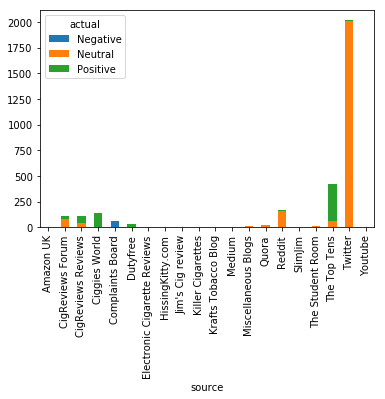

In [78]:
pd.crosstab(correct.source, correct.actual).plot(kind='bar', stacked=True);

In [81]:
correct.loc[73373, 'content']
correct.loc[73373, 'title']
correct.loc[73373, 'meta']
correct.loc[73373, ['actual', 'pred']]

'@truthinitiative @FDATobacco Untruthinitative Juul announced these changes 2 days ago they are removing the flavor pods that " are aimed at children" out of retail stores. But that\'s not enough for the Untruth you want e cigarettes banned so people will start smoking cigarettes again. save your funding TRUTH'

'@truthinitiative @FDATobacco Untruthinitative Juul'

[{'key': 'Brand', 'value': 'JUUL'},
 {'key': 'Product Category', 'value': 'E-cigarette'}]

actual    Neutral
pred      Neutral
Name: 73373, dtype: object

In [88]:
correct.loc[5303, 'content']
correct.loc[5303, 'title']
correct.loc[5303, 'meta']
correct.loc[5303, ['actual', 'pred']]

'Cool and sweet. lighter and smoother than ordinary American cigarettes.'

'Sampoerna A Mild Menthol Burst: Cool and sweet. lighter and smoother than ordinary'

[{'key': 'Rating', 'value': '5'},
 {'key': 'Brand', 'value': 'Sampoerna'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Product', 'value': 'Sampoerna A Mild Menthol Burst'},
 {'key': 'Quality / Overall', 'value': 'cool'},
 {'key': 'Taste', 'value': 'sweet'},
 {'key': 'Strength', 'value': 'Lighter'},
 {'key': 'Strength', 'value': 'smoother'}]

actual    Positive
pred      Positive
Name: 5303, dtype: object

In [87]:
correct[correct.actual=='Negative'].head()

,actual,pred,correct,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
54059,Negative,Negative,True,Discussion,I paid £7.95,2013-05-05T18:30:00.000Z,1f45d567-a5e0-438e-b629-c39283597ff8,None,False,True,True,None,https://www.cigreviews.com/forums/marlboro-cig...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-20T09:42:37.616Z,Negative,CigReviews Forum,"5.80 for pack of Marlboros today, omg:pipesdad..."
57690,Negative,Negative,True,Product Review,i bought a carton of marlbro menthol black 100...,2017-03-31T18:30:00.000Z,d9affd90-f3f9-4354-8300-e60d7302f9c0,None,False,True,False,None,https://www.complaintsboard.com/complaints/phi...,"[{'key': 'Company', 'value': 'PMI'}, {'key': '...",2018-10-23T11:36:20.388Z,Negative,Complaints Board,all the cigarettes were broke at the filter
56889,Negative,Negative,True,Product Review,I purchased a packet of Longbeach Rich Blues i...,2018-10-02T18:30:00.000Z,099d7c2b-7ec6-4106-a343-b57191dd8c90,https://www.complaintsboard.com/thumb.php?src=...,False,True,True,None,https://www.complaintsboard.com/complaints/pal...,"[{'key': 'Country / Region', 'value': 'United ...",2018-12-11T11:32:10.993Z,Very Negative,Complaints Board,Pall Mall / bad tabacco:Jenaqua:I purchased a ...
57378,Negative,Negative,True,Product Review,I am also having issues with sterling my husba...,2011-09-08T18:30:00.000Z,c144f9e8-057b-4d8a-a21a-0c9177b19ee9,None,False,True,False,None,https://www.complaintsboard.com/complaints/ste...,"[{'key': 'Brand', 'value': 'Sterling'}, {'key'...",2018-10-23T11:08:51.742Z,Negative,Complaints Board,"Sterling Cigarettes, comment: I am also having..."
57681,Negative,Negative,True,Product Review,Hello.\nI also purchase bond street Gold ..\nR...,2017-11-13T18:30:00.000Z,feba84a1-8c33-4938-84ec-ba507066a64f,None,False,True,True,None,https://www.complaintsboard.com/complaints/bon...,"[{'key': 'Brand', 'value': 'Bond Street Smokes...",2018-10-24T07:42:51.705Z,Very Negative,Complaints Board,bond street Gold/ toothpick in it


In [90]:
correct.loc[57690, 'content']
correct.loc[57690, 'title']
correct.loc[57690, 'meta']
correct.loc[57690, ['actual', 'pred']]

'i bought a carton of marlbro menthol black 100s in a box from admiral on west ave in jackson michigan and when i got home and opened the carton there was seven packs that all the cigarettes were broke at the filter. i called admiral and they said to contact you that there was nothing they could do about it due to state laws that say you cannot return or exchange any tobacco products. so now im stuck with them.. i am very upset over this. and want either my money refunded and you can send a box for me to return them or send me a coupon for a free carton. and i am not going to wait for weeks for this. i did not wait to pay for them so i should not have to wait to recieve my credit. you can email me the printable coupons or you can send me my refund asap. my email is jnovak844@yahoo.com. my name is joseph novak. date of birth is 06-02-1977. my address is 1190 sherman blvd east. jackson. michigan. 49201.. my return phone number is [protected]. please take care of this asap. thank you.'

' all the cigarettes were broke at the filter'

[{'key': 'Company', 'value': 'PMI'},
 {'key': 'Brand', 'value': 'Marlboro'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Product', 'value': 'Marlboro Black Menthol'},
 {'key': 'Quality / Overall', 'value': 'broken'}]

actual    Negative
pred      Negative
Name: 57690, dtype: object